<a href="https://colab.research.google.com/github/james-lucius/qureca_ADEQUATE/blob/main/M9_47_QNNs_4_7_Example_Iris_Flowers_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://gitlab.com/qworld/qeducation/educational-materials/adequate-qbook1/raw/main/qworld/images/adq_1.png" align="left" width=450>

_prepared by Claudia Zendejas-Morales_

## 4.7 Example: Iris Flowers Classification

Let's look at a complete example using [Qiksit](https://www.ibm.com/quantum/qiskit).

We are going to use one of the toy datasets provided by the
scikit-learn package: the "[Iris Plants dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-plants-dataset)." This dataset has $150$ samples with $4$ numerical features each that can be used to characterize whether an iris flower is one of three classes: Iris-Setosa, Iris-Versicolour, or Iris-Virginica. The label of each sample can be either $0$, $1$, or $2$, respectively.

The goal of the QFNN will be to train a model capable of distinguishing between the three classes given the features provided in the dataset.

Setting up the environment:

In [ ]:
!pip install qiskit[visualization]==1.4.2 &> /dev/nul     # use "&> /dev/null" so that the standard output of the installation is not displayed
!pip install qiskit-machine-learning==0.8.0 &> /dev/nul

print("Setup completed")

Setup completed


We load the dataset and separate the features and labels into two different variables:

In [ ]:
from sklearn.datasets import load_iris

iris_data = load_iris()

features = iris_data.data
labels = iris_data.target

Let's print the description of the dataset and see what is inside:

In [ ]:
print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

First, we'll normalize the features. That is, we'll apply a simple transformation to represent all features on the same scale. In our case, we compress all features to the range $[0,1]$. Normalization is a common technique in ML and often leads to improved numerical stability and convergence of an algorithm.

We can use scikit-learn's `MinMaxScaler` to do this. Without specifying any parameters, this does exactly what is required: it maps the data to the range $[0,1]$.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

Let's see what our data looks like, let's plot the features in pairs:

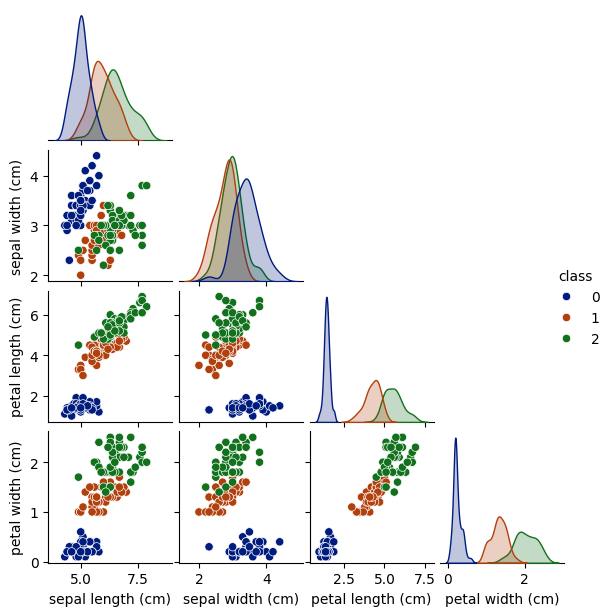

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

fig = sns.pairplot(df, hue="class", palette="dark", corner=True)
fig.fig.set_size_inches(6, 6)

In the plots, we see that class $0$ can be easily separated from the other two classes, while classes $1$ and $2$ sometimes overlap, especially with regard to the feature called "sepal width."

Our feature map of choice will be [ZZFeatureMap](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ZZFeatureMap). This is one of the standard feature maps in the Qiskit circuit library. We pass the quantity `num_features` as the `feature_dimension`, which means the feature map will have `num_features` or `4` qubits.

We decompose the feature map into its constituent gates to observe its pattern.

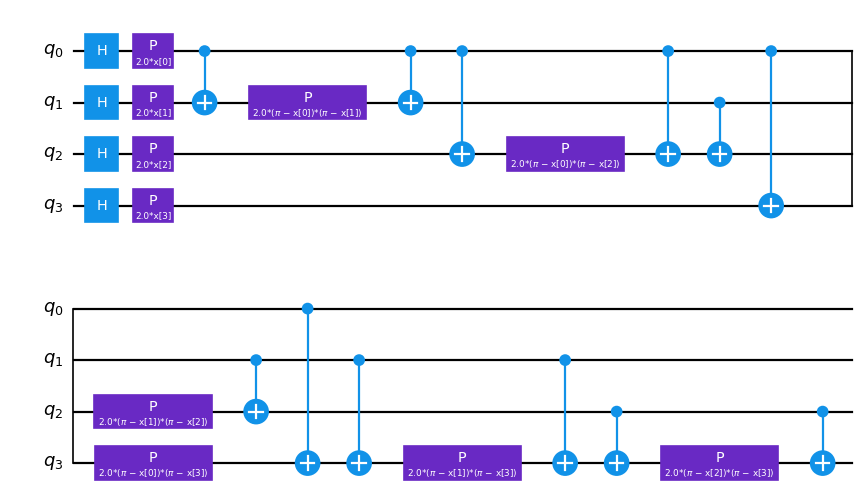

In [ ]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="textbook", scale=0.8, fold=15)

If we look closely at the feature map circuit, we'll notice the parameters `x[0], ..., x[3]`. These are placeholders for our features.

Now we create and draw our ansatz, choosing [EfficientSU2](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.EfficientSU2). Note the repetitive structure of the ansatz circuit. We define the number of these repetitions using the `reps` argument.

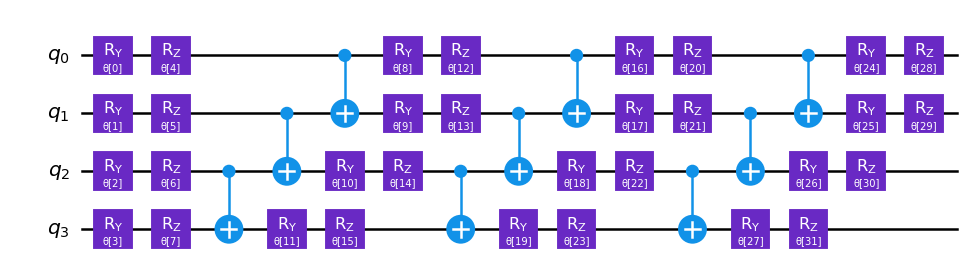

In [ ]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="textbook", scale=0.9, fold=15)

This circuit has $32$ parameters named `θ[0], ..., θ[31]`. These are the classifier's trainable weights.

Next, we chose the [COBYLA](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.optimizers.COBYLA.html) optimization algorithm to use in the training process. This algorithm will allow us to speed up the training process, as it is a gradient-free optimizer. You can explore [other optimizers](https://qiskit-community.github.io/qiskit-machine-learning/apidocs/qiskit_machine_learning.optimizers.html) available in Qiskit.

In [ ]:
from qiskit_machine_learning.optimizers import COBYLA

optimizer = COBYLA(maxiter=300)

We define a function called `callback_plot`, which will be called during the execution of the training process, it will plot the progress of the cost function value as it is modified.

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display


objective_func_vals = []                              # to store the full history

def callback_plot(weights, obj_func_eval):
  plt.clf()
  objective_func_vals.append(obj_func_eval)
  plt.title("Loss function value versus iteration")
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.plot(range(len(objective_func_vals)), objective_func_vals)
  display(plt.gcf())
  clear_output(wait=True)

Before training a model, we must split the dataset into two parts: a training dataset and a test dataset. We will use the former to train the model and the latter to verify how well our model perform with unseen data.

We will use scikit-learn for this step.

In [ ]:
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.utils import algorithm_globals


algorithm_globals.random_seed = 4242    # specify a seed so that the results are reproducible

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

We'll use the [VQC](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.algorithms.VQC.html) class for our QFNN; it takes a feature map and an ansatz. Training may take some time, so be patient.

Training time: 259 seconds


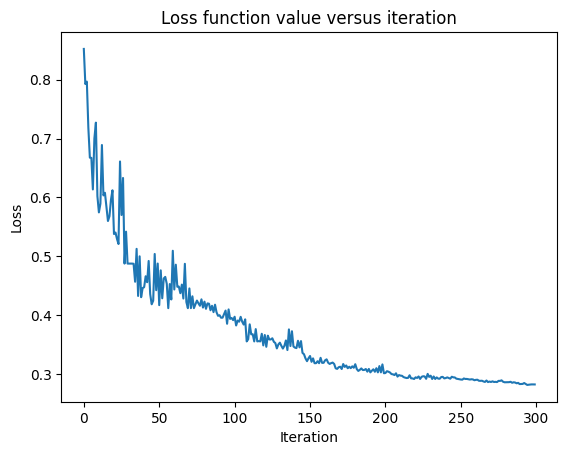

In [ ]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    feature_map=feature_map,                          # ZZFeatureMap
    ansatz=ansatz,                                    # EfficientSU2
    optimizer=optimizer,                              # COBYLA
    loss='squared_error',                             # loss function
    callback=callback_plot                            # function that will plot the value of the loss function
)

objective_func_vals = []                              # we make sure the history is empty

start = time.time()
vqc.fit(train_features, train_labels)                 # adjust the data
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")     # how long the training took

Let's see how the quantum model works on the dataset, both the training and test data.

In [ ]:
train_score = vqc.score(train_features, train_labels)
test_score = vqc.score(test_features, test_labels)

print(f"QFNN score on the training dataset: {train_score:.2f}")
print(f"QFNN score on the test dataset:     {test_score:.2f}")

QFNN score on the training dataset: 0.92
QFNN score on the test dataset:     1.00
